<a href="https://colab.research.google.com/github/stefdewildt/NLP/blob/wijzigingen-Nicky/NLP1_2025_Practical_1_(student).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused.

Generally, any function that we already use or import in the notebook can be used. Besides those, importing something like `deepcopy` or `tqdm` that does not change the implementation of the algorithms is fine. Functions that change or simplify the way you would implement the algorithm, including text processing functions from libraries like `sklearn`, `pandas` or `nltk` are not allowed unless specified (e.g. `ngrams` and `PorterStemmer` from `ntlk`). If you have questions about any specific function or library, please discuss this with your TA who will be the one grading your assignment.

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [78]:
!python --version


Python 3.12.12


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [79]:
import hashlib
import json
import math
import typing
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import tqdm
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
from scipy.sparse import csr_matrix


## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [80]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json


--2025-11-07 10:57:21--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.1’

sent_lexicon.1      100%[===================>] 647.05K  --.-KB/s    in 0.04s   

2025-11-07 10:57:21 (14.6 MB/s) - ‘sent_lexicon.1’ saved [662577/662577]

--2025-11-07 10:57:21--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercont

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [81]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)

print("Total number of reviews:", len(reviews), "\n")


def print_sentence_with_pos(s):
    print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))


for i, r in enumerate(reviews):
    print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
    print_sentence_with_pos(r["content"][0])
    if i == 4:
        break

c = Counter()
for review in reviews:
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
    print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (4pts)



A traditional approach to automatically classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative) or a sentiment score (e.g., a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005). The path of the loaded lexicon is `"sent_lexicon"`.

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. For those lemmas you are free to use any entry, so it is fine to only keep one, e.g. the first or last one.

In [82]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    line_cnt = 0
    for line in f:
        print(line.strip())
        line_cnt += 1
        if line_cnt > 4:
            break


type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Given such a sentiment lexicon, there are ways to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this classifier using the provided structure below. (1 pt)

In [83]:

class SentimentLexicon:
    def __init__(
        self,
        lexicon_path: str = "./sent_lexicon",
        threshold: float = 8.0,
        weight: float = 1.0,
    ) -> None:
        """Sentiment classifier using a lexicon approach.

        Args:
            lexicon_path (str, optional): the location of the sentiment lexicon file. Defaults to "./sent_lexicon".
            threshold (float, optional): the threshold used in classification. Defaults to 8.0.
            weight (float, optional): the weight assigned to words with strong polarity. Defaults to 1.0.
        """
        self.lexicon_path = lexicon_path
        self.threshold = threshold
        self.weight = weight

        self.lexicon: dict[str, dict[str, str]]

        ##################
        # YOUR CODE HERE #
        ##################
        self.lexicon = {}
        with open(self.lexicon_path, mode = 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                entry = {}
                for p in parts:
                    key, val = p.split('=')
                    entry[key] = val

                word = entry["word1"]
                if word not in self.lexicon:
                    self.lexicon[word] = {
                        "priorpolarity": entry["priorpolarity"],
                        "type": entry["type"]
                    }

        print(f'Example of lemma: {list(self.lexicon.items())[1]}')

    def fit(
        self, documents: list[list[str]], labels: list[typing.Literal["POS", "NEG"]]
    ) -> None:
        """Fit the classifer according to the input features and target labels.

        For the `SentimentLexicon` classifier, there are no parameters to learn.

        Args:
            documents (list[list[str]]): the list of documents as a list of tokens.
            labels (list[str]): the list of labels
        """

        pass

    def predict(self, documents: list[list[str]]) -> list[typing.Literal["POS", "NEG"]]:
        """Perform classification on input documents.

        Args:
            documents (list[list[str]]): the list of documents as a list of tokens.

        Returns:
            list[str]: predicted labels.
        """
        ##################
        # YOUR CODE HERE #
        ##################
        predictions = []
        for doc in documents:
            score = 0

            for word in doc:
                word = word.lower()
                if word in self.lexicon:

                    pol = self.lexicon[word]['priorpolarity']
                    strength = self.lexicon[word]['type']

                    if pol == 'positive':
                        inter_score = 1
                    elif pol == 'negative':
                        inter_score = -1
                    else:
                        inter_score = 0

                    # words with strong polarity
                    if strength == 'strongsubj':
                        inter_score *= self.weight

                    score += inter_score

            if score > self.threshold:
                predictions.append('POS')
            else:
                predictions.append('NEG')

        return predictions
        raise NotImplementedError


In [84]:
#debug cell
sentiment_lex = SentimentLexicon()

Example of lemma: ('abandonment', {'priorpolarity': 'negative', 'type': 'weaksubj'})


#### (Q1.2) Implement functions to transform the dataset to the needed data structures. (0.5pt)

In our current implementation, the classifier's `fit` and `predict` methods expect a list of corpus documents represented as `list[list[str]]`, and labels as a `list[str]`. However, our data is represented as `list[dict[str, Any]]`. Before we can fit and classify, we'll need to define a function to transform our data to the desired data structure.

In [85]:
def extract_labels(
    documents: list[dict[str, typing.Any]],
) -> list[typing.Literal["POS", "NEG"]]:
    """Converts a list of reviews to a list of labels.

    Args:
        documents (list[dict[str, Any]]): the reviews as a list of dicts.

    Returns:
        list[str]: the labels as a list of str
    """
    ##################
    # YOUR CODE HERE #
    ##################
    sentiment_list = []
    for doc in documents:
        sentiment_list.append(doc['sentiment'])

    return sentiment_list
    # raise NotImplementedError


def extract_unigrams(
    documents: list[dict[str, typing.Any]], lower: bool = True
) -> list[list[str]]:
    """Converts a list of reviews to a list of unigram token lists.

    Args:
        documents (list[dict[str, typing.Any]]): the reviews as a list of dicts.
        lower (bool, optional): whether to lowercase the review tokens. Defaults to True.

    Returns:
        list[list[str]]: the list of unigram tokens
    """
    ##################
    # YOUR CODE HERE #
    ##################
    unigram_list_list = []

    for doc in documents:
        content = doc['content']
        if lower:
            unigrams = [word.lower() for sentence in content for word, pos in sentence]
        else:
            unigrams = [word for sentence in content for word, pos in sentence]
        unigram_list_list.append(unigrams)

    return unigram_list_list
    # raise NotImplementedError


#### (Q1.3) Implement a function to compute the accuracy of a classification. (0.5pt)

Finally, we need to implement a classification evaluation metric. For this practical, we'll be using [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_classification), which is defined as the proportion of correct classifications.

In [86]:
def accuracy(y_pred: list[str], y_true: list[str]) -> float:
    """Computes the accuracy score.

    Args:
        y_pred (list[str]): the predicted labels
        y_true (list[str]): the ground truth labels

    Returns:
        float: the accuracy score
    """
    ##################
    # YOUR CODE HERE #
    ##################
    count = 0
    for pred, true in zip(y_pred, y_true):
        if pred == true:
            count += 1

    return count / len(y_pred)
    # raise NotImplementedError


Now train, predict and evaluate your classifier using the implemented functions. Make sure to print the final accuracy score.

In [87]:
##################
# YOUR CODE HERE #
##################
# raise NotImplementedError


lexicon = SentimentLexicon()
unigrams = extract_unigrams(reviews)
y_true = extract_labels(reviews)
y_fit = lexicon.predict(unigrams)
acc = accuracy(y_fit, y_true)

print(f"Accuracy: {acc}")

Example of lemma: ('abandonment', {'priorpolarity': 'negative', 'type': 'weaksubj'})
Accuracy: 0.685


#### (Q1.4) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$

In [88]:
##################
# YOUR CODE HERE #
##################
better_lexicon = SentimentLexicon(weight=2)
y_fit = better_lexicon.predict(unigrams)
acc = accuracy(y_fit, y_true)
print(f"Weighted Accuracy: {acc}")
# raise NotImplementedError


Example of lemma: ('abandonment', {'priorpolarity': 'negative', 'type': 'weaksubj'})
Weighted Accuracy: 0.6775


#### (Q1.5) A better threshold (1pt)

Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

\####################
\# YOUR ANSWER HERE \#
\####################

Now implement your agorithm by adjusting the previously created `SentimentLexicon` class. Make sure to print the final accuracy score and compare to the previous results.

Note: you might need to adjust your threshold.

In [89]:
class BetterSentimentLexicon(SentimentLexicon):
    def predict(self, documents: list[list[str]]) -> list[str]:
        """Perform classification on input documents.

        Args:
            documents (list[list[str]]): the list of documents as a list of tokens.

        Returns:
            list[str]: predicted labels.
        """
        # compute average document length for scaling

        ##################
        # YOUR CODE HERE #
        ##################
        avg_len = sum(len(doc) for doc in documents) / len(documents)
        predictions = []
        for doc in documents:
            score = 0

            for word in doc:
                word = word.lower()
                if word in self.lexicon:

                    pol = self.lexicon[word]['priorpolarity']
                    strength = self.lexicon[word]['type']

                    if pol == 'positive':
                        inter_score = 1
                    elif pol == 'negative':
                        inter_score = -1
                    else:
                        inter_score = 0

                    # words with strong polarity
                    if strength == 'strongsubj':
                        inter_score *= self.weight

                    score += inter_score

            scaled_threshold = self.threshold * len(doc) / avg_len

            if score > scaled_threshold:
                predictions.append('POS')
            else:
                predictions.append('NEG')

        return predictions
        raise NotImplementedError


In [90]:
##################
# YOUR CODE HERE #
##################
# raise NotImplementedError

even_better_lexicon = BetterSentimentLexicon(weight=3)
y_fit = even_better_lexicon.predict(unigrams)
acc = accuracy(y_fit, y_true)
print(f"Accuracy for scaled threshold: {acc}")


Example of lemma: ('abandonment', {'priorpolarity': 'negative', 'type': 'weaksubj'})
Accuracy for scaled threshold: 0.671


# Naive Bayes (10pt)

Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

\####################
\# YOUR ANSWER HERE \#
\####################

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. (2pts)


In [91]:
class NaiveBayes:
    def __init__(self, smoothing: float = 0):
        """Naive Bayes classifier for multinomial data.

        Args:
            smoothing (float, optional): the Laplacian smoothing factor. Defaults to 0.
        """
        self.smoothing = smoothing

        # The datastructures necessary for NaiveBayes
        self.vocab: set[str] = set()

        self.prior: dict[typing.Literal["POS", "NEG"], float] = {
            "POS": 0,
            "NEG": 0,
        }

        self.token_counts: dict[str, dict[typing.Literal["POS", "NEG"], int]] = (
            defaultdict(
                lambda: {"POS": 0, "NEG": 0},
            )
        )

        self.cond_prob: dict[str, dict[typing.Literal["POS", "NEG"], float]] = (
            defaultdict(
                lambda: {"POS": 0.0, "NEG": 0.0},
            )
        )

    def fit(
        self,
        documents: list[list[typing.Any]],
        labels: list[typing.Literal["POS", "NEG"]],
    ) -> None:
        """Fit the classifer according to the input features and target labels.

        Args:
            documents (list[list[str]]): the list of documents as a list of tokens
            labels (list[str]): the list of labels
        """
        ##################
        # YOUR CODE HERE #
        ##################

        # priors
        count_labels = Counter(labels)
        self.prior["POS"] = count_labels["POS"] / len(documents)
        self.prior["NEG"] = count_labels["NEG"] / len(documents)

        # set vocab
        for doc in documents:
            for token in doc:
                self.vocab.add(token)

        # count tokens
        for doc, label in zip(documents, labels):
            for token in doc:
                token = token.lower()
                self.token_counts[token][label] += 1

        # compute conditional probabilities, and Laplace smoothing
        vocab_size = len(self.vocab)

        total_tokens = {
            "POS": sum(self.token_counts[tok]["POS"] for tok in self.vocab),
            "NEG": sum(self.token_counts[tok]["NEG"] for tok in self.vocab)
        }

        for token in self.vocab:
            for label in ["POS", "NEG"]:
                count = self.token_counts[token][label]
                total = total_tokens[label]
                self.cond_prob[token][label] = (count + self.smoothing) / (total + self.smoothing * vocab_size)

        # raise NotImplementedError

    def predict(
        self, documents: list[list[typing.Any]]
    ) -> list[typing.Literal["POS", "NEG"]]:
        """Perform classification on input documents.

        Args:
            documents (list[list[str]]): the list of documents as a list of tokens

        Returns:
            list[str]: predicted labels
        """
        ##################
        # YOUR CODE HERE #
        ##################
        predictions = []

        for doc in documents:
            log_probs = {"POS": 0, "NEG": 0}

            for label in ["POS", "NEG"]:
                log_probs[label] += math.log(self.prior[label])

                for token in doc:
                    token = token.lower()
                    if token not in self.vocab:
                        continue

                    if token in self.vocab:
                        p = self.cond_prob[token][label]

                        if p == 0:

                            # log_probs[label] += float('-inf')
                            break
                        else:
                            log_probs[label] += math.log(p)
                    else:
                        # for unseen word
                        if self.smoothing > 0:
                            log_probs[label] += math.log(self.smoothing / (self.smoothing * len(self.vocab)))
                        else:
                            continue

            if log_probs["POS"] > log_probs["NEG"]:
                predictions.append("POS")
            else:
                predictions.append("NEG")

        return predictions

        # raise NotImplementedError


Now train, predict and evaluate your classifier on the reviews dataset. Make sure to select the right reviews for the train and test sets.

In [92]:
##################
# YOUR CODE HERE #
##################
train_docs = []
test_docs = []
for r in reviews:
    if 0 <= r["cv"] <= 899:
        train_docs.append(r)
    elif 900 <= r["cv"] <= 999:
        test_docs.append(r)

X_train = extract_unigrams(train_docs, lower=True)
y_train = extract_labels(train_docs)

X_test = extract_unigrams(test_docs, lower=True)
y_test = extract_labels(test_docs)
# raise NotImplementedError


In [93]:
naive_bayes = NaiveBayes()
naive_bayes.fit(X_train, y_train)

In [94]:
# predicting
y_pred = naive_bayes.predict(X_test)

# accuracy
acc = accuracy(y_pred, y_test)
print('Naive Bayes accuracy:', acc)

Naive Bayes accuracy: 0.395


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

\####################
\# YOUR ANSWER HERE \#
\####################

In [95]:
##################
# YOUR CODE HERE #
##################
train_docs_neg = []
for r in reviews:
    # POS reviews unchanged (train: 000–899, test: 900–999)
    if r["sentiment"] == "POS":
        if 0 <= r["cv"] <= 899:
            train_docs_neg.append(r)

    # NEG reviews restricted
    elif r["sentiment"] == "NEG":
        if 0 <= r["cv"] <= 89:  # only 90 negatives for training
            train_docs_neg.append(r)


X_train_neg = extract_unigrams(train_docs_neg, lower=True)
y_train_neg = extract_labels(train_docs_neg)
# raise NotImplementedError

In [96]:
naive_bayes = NaiveBayes()
naive_bayes.fit(X_train_neg, y_train_neg)
# predicting
y_pred = naive_bayes.predict(X_test)

# accuracy
acc = accuracy(y_pred, y_test)
print('Naive Bayes accuracy:', acc)

Naive Bayes accuracy: 0.5


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction

$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$

for a word $w_i$ becomes

$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$


#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy for $\kappa = 1$ and $\kappa = 3.5$. Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.

In [97]:
##################
# YOUR CODE HERE #
##################
naive_bayes = NaiveBayes(smoothing=1)
naive_bayes.fit(X_train, y_train)
# predicting
y_pred = naive_bayes.predict(X_test)

# accuracy
acc = accuracy(y_pred, y_test)
print('Naive Bayes accuracy:', acc)
# raise NotImplementedError


Naive Bayes accuracy: 0.825


In [98]:
naive_bayes = NaiveBayes(smoothing=3.5)
naive_bayes.fit(X_train, y_train)
# predicting
y_pred = naive_bayes.predict(X_test)

# accuracy
acc = accuracy(y_pred, y_test)
print('Naive Bayes accuracy:', acc)

Naive Bayes accuracy: 0.845


**FROM NOW ON, ALWAYS USE SMOOTHING (YOU CAN CHOOSE $\kappa$) WHEN USING THE NAIVE BAYES CLASSIFIER**

## Cross-Validation (1pt)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the mean and standard deviation of the accuracies. (1pt)

In [99]:
def cross_validation_splits(
    documents: list[dict[str, typing.Any]],
    num_folds: int = 10,
) -> list[tuple[list, list]]:
    """Splits the reviews into disjoint subsets of train/test splits.

    Args:
        documents (list[dict[str, typing.Any]]): the reviews as dicts.
        num_folds (int, optional): the number of cross-validation folds. Defaults to 10.

    Returns:
        list[tuple[list, list]]: a list of train/test folds
    """
    ##################
    # YOUR CODE HERE #
    ##################
    fold_list = []

    for i in range(num_folds):
        # round robin splits based on cv index
        # use modulo to select right
        test_docs = [doc for doc in documents if doc["cv"] % num_folds == i]
        train_docs = [doc for doc in documents if doc["cv"] % num_folds != i]
        fold_list.append((train_docs, test_docs))

    return fold_list

    # raise NotImplementedError


Now re-train the Naive Bayes classifier on each fold, and evaluate on that fold's held-out test set. Make sure to print the accuracy mean and standard deviation.

Note: you may use `tqdm` to add progress bars

In [131]:
##################
# YOUR CODE HERE #
##################
folds = cross_validation_splits(reviews)
accs = []
for i, (train_docs, test_docs) in enumerate(folds):
    X_train = extract_unigrams(train_docs, lower=True)
    y_train = extract_labels(train_docs)
    X_test = extract_unigrams(test_docs, lower=True)
    y_test = extract_labels(test_docs)

    model = NaiveBayes(smoothing=1)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy(preds, y_test)
    accs.append(acc)
    print(f"Fold {i+1} accuracy: {acc}")


# raise NotImplementedError


Fold 1 accuracy: 0.79
Fold 2 accuracy: 0.835
Fold 3 accuracy: 0.805
Fold 4 accuracy: 0.825
Fold 5 accuracy: 0.78
Fold 6 accuracy: 0.845
Fold 7 accuracy: 0.83
Fold 8 accuracy: 0.775
Fold 9 accuracy: 0.83
Fold 10 accuracy: 0.84


In [101]:
mean_acc = np.mean(accs)
std_acc = np.std(accs)
print(f"Average accuracy: {mean_acc}")
print(f"Accuracy std: {std_acc}")

Average accuracy: 0.8154999999999999
Accuracy std: 0.02454078238361602


**FROM NOW ON, ALWAYS USE CROSS VALIDATION WHEN EVALUATING A CLASSIFIER**

## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and
hash different inflections of a word to the same feature in the BoW
vector space.


#### (Q2.6): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)

First we'll need to adjust our `extract_unigrams` function to extract stemmed unigrams. Use the provided structure below.

In [102]:
def extract_stems(
    documents: list[dict[str, typing.Any]], stemmer: PorterStemmer, lower: bool = True
) -> list[list[str]]:
    """Extract stemmed unigrams from a corpus of documents.

    Args:
        documents (list[dict[str, Any]]): the list of documents
        stemmer (PorterStemmer): the stemmer to use when stemming documents
        lower (bool, optional): whether to lowercase tokens before stemming. Defaults to True.

    Returns:
        list[list[str]]: the list of token lists
    """
    ##################
    # YOUR CODE HERE #
    ##################
    stemmed_results = []
    for doc in documents:
        stems = []
        for sentence in doc["content"]:
            for token, _ in sentence:
                word = token.lower() if lower else token
                stems.append(stemmer.stem(word))
        stemmed_results.append(stems)
    return stemmed_results


Now re-train your Naive Bayes classifier. Use cross-validation to evaluate the classifier. Use nltk's `PorterStemmer` to stem the document tokens.


In [103]:
##################
# YOUR CODE HERE #
##################

stemmed = PorterStemmer()

folds = cross_validation_splits(reviews)
accs = []
for i, (train_docs, test_docs) in enumerate(folds):
    X_train_stem = extract_stems(train_docs,stemmed, lower=True)
    y_train = extract_labels(train_docs)
    X_test_stem = extract_stems(test_docs,stemmed, lower=True)
    y_test = extract_labels(test_docs)

    model = NaiveBayes(smoothing=1)
    model.fit(X_train_stem, y_train)
    preds = model.predict(X_test_stem)
    acc = accuracy(preds, y_test)
    accs.append(acc)
    print(f"Fold {i+1} accuracy: {acc}")


Fold 1 accuracy: 0.78
Fold 2 accuracy: 0.84
Fold 3 accuracy: 0.805
Fold 4 accuracy: 0.84
Fold 5 accuracy: 0.775
Fold 6 accuracy: 0.84
Fold 7 accuracy: 0.82
Fold 8 accuracy: 0.775
Fold 9 accuracy: 0.83
Fold 10 accuracy: 0.83


#### (Q2.7) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)

Give actual numbers. You can use the training set from Q2.4 to determine these.

In [104]:
##################
# YOUR CODE HERE #
##################
# since looking at 2.4 do not need cross validation
unstem = extract_unigrams(train_docs, lower=True)
stem = extract_stems(train_docs, stemmed, lower=True)

# get unqiue entries
vocab_stem = set()
vocab_unstem = set()

# find number of tokens in each type of data
for doc in stem:
    for token in doc:
        vocab_stem.add(token)


for doc in unstem:
    for token in doc:
        vocab_unstem.add(token)

print(f"Vocabulary size of unstemmed {len(vocab_unstem)}")
print(f"Vocabulary size of stemmed {len(vocab_stem)}")


Vocabulary size of unstemmed 45642
Vocabulary size of stemmed 32667


### N-grams (2.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-gram** features.






#### (Q2.8) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (2pt)

We'll need to adjust our `extract_unigrams` function to extract stemmed unigrams. Use the provided structure below. You can use nltk's `ngrams` function to extract n-grams from the sentences.

In [105]:
def extract_ngrams(
    documents: list[dict], n_values: typing.Sequence[int], lower: bool = True
) -> list[list[typing.Any]]:
    """Extract n-gram features from the corpus of documents.

    Args:
        documents (list[dict]): the list of documents
        n_values (typing.Sequence[int]): the different sizes of n-grams to take (1=unigram, 2=bigram)
        lower (bool, optional): whether to lowercase the tokens. Defaults to True.

    Returns:
        list[list[tuple[str]]]: the n-gram tokens
    """
    ##################
    # YOUR CODE HERE #
    ##################
    stemmer = PorterStemmer()
    results = []
    for doc in documents:
      tokens = []
      n_grams = []
      for sentence in doc["content"]:
        for token, _ in sentence:
          # do the stemming
          token = token.lower() if lower else token
          tokens.append(stemmer.stem(token))

      # check which gram
      for n in n_values:
        '''
        # faster and avoids 1-gram tuples (stemming algready is in n-gram)
        if n == 1:
          n_grams.extend(tokens)
        else:
        '''
        grams = ngrams(tokens, n)
        n_grams.extend(grams)

      results.append(n_grams)
    return results



Now re-train your Naive Bayes classifier with **uni- and bigram** tokens. Report accuracy and compare it with that of the approaches you have previously implemented. Use cross-validation when evaluating your classifier. (1pt)

In [106]:
##################
# YOUR CODE HERE #
##################

def stringify_ngrams(docs: list[list[object]]) -> list[list[str]]:
    return [[" ".join(t) if isinstance(t, tuple) else t for t in doc] for doc in docs]

folds = cross_validation_splits(reviews)
accs = []

for i, (train_docs, test_docs) in enumerate(folds):
    X_train = extract_ngrams(train_docs,n_values =[1,2], lower=True)
    y_train = extract_labels(train_docs)
    X_test = extract_ngrams(test_docs,n_values =[1,2], lower=True)
    y_test = extract_labels(test_docs)

    X_train_str = stringify_ngrams(X_train)
    X_test_str  = stringify_ngrams(X_test)

    model = NaiveBayes(smoothing=1)
    model.fit(X_train_str, y_train)
    preds = model.predict(X_test_str)
    acc = accuracy(preds, y_test)
    accs.append(acc)
    print(f"Fold {i+1} accuracy: {acc}")


Fold 1 accuracy: 0.79
Fold 2 accuracy: 0.845
Fold 3 accuracy: 0.835
Fold 4 accuracy: 0.87
Fold 5 accuracy: 0.805
Fold 6 accuracy: 0.855
Fold 7 accuracy: 0.845
Fold 8 accuracy: 0.815
Fold 9 accuracy: 0.84
Fold 10 accuracy: 0.83


Now re-train your Naive Bayes classifier with **uni-, bi- and trigram** tokens. Report accuracy and compare it with that of the approaches you have previously implemented. Use cross-validation when evaluating your classifier. (1pt)

In [107]:
##################
# YOUR CODE HERE #
##################
def stringify_ngrams(docs: list[list[object]]) -> list[list[str]]:
    return [[" ".join(t) if isinstance(t, tuple) else t for t in doc] for doc in docs]

folds = cross_validation_splits(reviews)
accs = []
for i, (train_docs, test_docs) in enumerate(folds):
    X_train = extract_ngrams(train_docs,n_values =[1,2,3], lower=True)
    y_train = extract_labels(train_docs)
    X_test = extract_ngrams(test_docs,n_values =[1,2,3], lower=True)
    y_test = extract_labels(test_docs)

    X_train_str = stringify_ngrams(X_train)
    X_test_str  = stringify_ngrams(X_test)

    model = NaiveBayes(smoothing=1)
    model.fit(X_train_str, y_train)
    preds = model.predict(X_test_str)
    acc = accuracy(preds, y_test)
    accs.append(acc)
    print(f"Fold {i+1} accuracy: {acc}")


Fold 1 accuracy: 0.785
Fold 2 accuracy: 0.825
Fold 3 accuracy: 0.83
Fold 4 accuracy: 0.855
Fold 5 accuracy: 0.815
Fold 6 accuracy: 0.845
Fold 7 accuracy: 0.85
Fold 8 accuracy: 0.83
Fold 9 accuracy: 0.84
Fold 10 accuracy: 0.835


#### (Q2.9): How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How do the number of features increase in the held-out training set (compared to Q2.8)? Do you expect this rate of increase to continue for (much) larger n-grams?

Use the held-out training set from training set from Q2.4 for this.


\####################
The number of features can grow exponentially in theory. This is because for a vocabulary size V, there can be feature space V to the power of n, where n is the number of n-grams. However with real data the vocabulary size is finite. This means that there cannot be an ngram that is for example longer then the sentence size. This would not make sence. The grwoth rate will eventaully plateau for larger n-grams.  
\####################

In [108]:
##################
# YOUR CODE HERE #
##################
# since looking at 2.4 do not need cross validation
unstem = extract_unigrams(train_docs, lower=True)
stem = extract_ngrams(train_docs,n_values=[1,2,3], lower=True)

# get unqiue entries
vocab_stem = set()
vocab_unstem = set()

# find number of tokens in each type of data
for doc in stem:
    for token in doc:
        vocab_stem.add(token)


for doc in unstem:
    for token in doc:
        vocab_unstem.add(token)

print(f"Vocabulary size of unstemmed {len(vocab_unstem)}")
print(f"Vocabulary size of ngram {len(vocab_stem)}")


Vocabulary size of unstemmed 45642
Vocabulary size of ngram 1340120




# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one major problem with the Naive Bayes classifier is that its performance deteriorates (becomes skewed) when it is being used with features which are not independent (i.e., are correlated). Another popular classifier that doesn’t assume feature independence is the Support Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/


#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (`sklearn.svm.LinearSVC`) using the unigram features collected for Naive Bayes.

sklearn's classifiers expect a different data structure than what we've been using so far. Instead of a list of tokens, we'll need to provide a (sparse) [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix). Each row represents a document, and each column represents a token. The value in each cell represents how often a token appears in a document.

Define a function below that takes a list of tokens and constructs a document-term matrix. While not mandatory, it's recommended to use scipy's `csr_matrix` to produce a sparse matrix representation. This avoids having to keep many 0 values in memory, and can speed up SVM training.

Hint: the documentation on the [`csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) is very helpful

In [109]:
def one_matrix(features: list[list[str]], vocab: dict[str, int] | None = None):
  if vocab == None:
    vocab = {}
    for doc in features:
      for tok in doc:
        if tok not in vocab:
          vocab[tok] = len(vocab)

  data = []
  indices = []
  indptr = [0]

  # compres duplicates into one entry with the total number
  for doc in features:
    counts = Counter(tok for tok in doc if tok in vocab)
    if counts:
        cols = [vocab[t] for t in counts.keys()]
        vals = list(counts.values())

        # keep column indices sorted within each row
        order = np.argsort(cols)
        indices.extend(np.asarray(cols, dtype=np.int32)[order])
        data.extend(np.asarray(vals, dtype=np.int64)[order])
    indptr.append(len(indices))

  # create matrix
  X = csr_matrix(
    (np.asarray(data, dtype=np.int64),
      np.asarray(indices, dtype=np.int32),
      np.asarray(indptr, dtype=np.int32)),
    shape=(len(features), len(vocab)),
    dtype=np.int64,
  )

  X.sort_indices()
  return X, vocab

def build_term_document_matrix(
    train_features: list[list[str]], test_features: list[list[str]]
) -> tuple[np.array, np.array]:
    """Converts a list of token lists to a document-term matrix.

    Args:
        train_features (list[list[str]]): the training token lists
        test_features (list[list[str]]): the testing token lists

    Returns:
        tuple[array, array]: a tuple of training and testing DTMs
    """
    ##################
    # YOUR CODE HERE #
    ##################
    # Build vocabulary from all documents
    csr_train, vocab = one_matrix(train_features)
    csr_test, _ = one_matrix(test_features, vocab)
    return csr_train, csr_test


Besides a document term matrix, sklearn also expects the labels to be a list of `int`. Using the structure provide, implement a function to convert the `str` labels to integers.

In [110]:
def convert_labels_to_ints(labels: list[str]) -> list[int]:
    """Converts a list of "POS" or "NEG" to 0 or 1.

    Args:
        labels (list[str]): the list of str labels

    Returns:
        list[int]: the list of int labels
    """
    ##################
    # YOUR CODE HERE #
    ##################
    for i in range(len(labels)):
      if labels[i] == "POS":
        labels[i] = 1
      if labels[i] == "NEG":
        labels[i] = 0

    return labels


Now train, predict and evaluate an SVM classifier. Compare the classification performance of the SVM classifier to that of the Naive Bayes classifier with smoothing. Use cross-validation to evaluate the performance of the classifiers.

You are not required to perform hyperparameter tuning, but it might be helpful.

In [111]:
##################
# YOUR CODE HERE #
##################
from sklearn.svm import LinearSVC

folds = cross_validation_splits(reviews)
accs = []
accs_svm = []
for i, (train_docs, test_docs) in enumerate(folds):

    X_train = extract_unigrams(train_docs, lower=True)
    y_train = extract_labels(train_docs)
    X_test = extract_unigrams(test_docs, lower=True)
    y_test = extract_labels(test_docs)

    # NaiveBayes
    model = NaiveBayes(smoothing=1)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy(preds, y_test)
    accs.append(acc)
    print(f"Fold {i+1} accuracy Naive: {acc}")

    # SVM
    X_tr, X_te = build_term_document_matrix(X_train, X_test)
    y_tr = convert_labels_to_ints(y_train)
    y_te = convert_labels_to_ints(y_test)

    svm = LinearSVC(random_state=42, max_iter=10000)
    svm.fit(X_tr, y_tr)
    preds_svm = svm.predict(X_te)


    acc_svm = accuracy(preds_svm, y_te)
    accs_svm.append(acc_svm)
    print(f"Fold {i+1} accuracy svm: {acc_svm}")






Fold 1 accuracy Naive: 0.79
Fold 1 accuracy svm: 0.81
Fold 2 accuracy Naive: 0.835
Fold 2 accuracy svm: 0.795
Fold 3 accuracy Naive: 0.805
Fold 3 accuracy svm: 0.8
Fold 4 accuracy Naive: 0.825
Fold 4 accuracy svm: 0.84
Fold 5 accuracy Naive: 0.78
Fold 5 accuracy svm: 0.85
Fold 6 accuracy Naive: 0.845
Fold 6 accuracy svm: 0.815
Fold 7 accuracy Naive: 0.83
Fold 7 accuracy svm: 0.845
Fold 8 accuracy Naive: 0.775
Fold 8 accuracy svm: 0.85
Fold 9 accuracy Naive: 0.83
Fold 9 accuracy svm: 0.875
Fold 10 accuracy Naive: 0.84
Fold 10 accuracy svm: 0.84


10


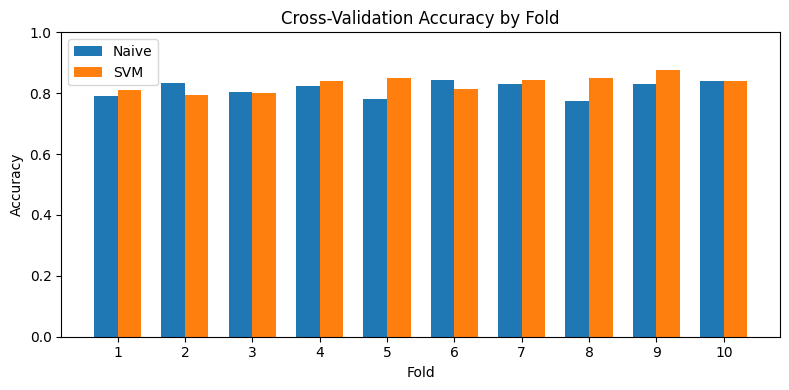

In [112]:

k = len(accs)
print(len(accs))
fold_idx = np.arange(1, k + 1)

fig, ax = plt.subplots(figsize=(8, 4))
width = 0.35
ax.bar(fold_idx - width/2, accs, width, label='Naive')
ax.bar(fold_idx + width/2, accs_svm, width, label='SVM')

ax.set_xticks(fold_idx)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.set_title('Cross-Validation Accuracy by Fold')
ax.legend()
fig.tight_layout()
plt.show()

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



#### (Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)

\####################
\# YOUR ANSWER HERE \#
\####################

Once again, we'll need to adjust our `extract_unigrams` function to extract (token, pos) tuples. Use the provided structure below.

In [119]:
def extract_pos_unigrams(
    documents: list[dict], lower: bool = True
) -> list[list[tuple[str, str]]]:
    """Extracts (token, pos) tuples.

    Args:
        documents (list[dict]): the list of documents
        lower (bool, optional): whether to lowercase words. Defaults to True.

    Returns:
        list[list[tuple[str, str]]]: the list of (token, pos) tuple lists
    """
    results = []
    for doc in documents:
      token_pos = []
      for sentence in doc["content"]:
        for token, pos in sentence:
          token = token.lower() if lower else token
          token_pos.append((token, pos))
      results.append(token_pos)
    return results



Now train, predict and evaluate your SVM classifier, and compare to the SVM with only unigram features.

In [120]:
##################
# YOUR CODE HERE #
##################
folds = cross_validation_splits(reviews)
accs_svm_pos = []
for i, (train_docs, test_docs) in enumerate(folds):

    # see previous exercise for accuracy of svm with only unigram features
    X_train = extract_pos_unigrams(train_docs, lower=True)
    y_train = extract_labels(train_docs)
    X_test = extract_pos_unigrams(test_docs, lower=True)
    y_test = extract_labels(test_docs)

    # SVM
    X_tr, X_te = build_term_document_matrix(X_train, X_test)
    y_tr = convert_labels_to_ints(y_train)
    y_te = convert_labels_to_ints(y_test)

    #needed more iterations to converge
    svm = LinearSVC(random_state=42, max_iter=10000)
    svm.fit(X_tr, y_tr)
    preds_svm = svm.predict(X_te)


    acc_svm = accuracy(preds_svm, y_te)
    accs_svm_pos.append(acc_svm)
    print(f"Fold {i+1} accuracy svm pos: {acc_svm}")



Fold 1 accuracy svm pos: 0.82
Fold 2 accuracy svm pos: 0.795
Fold 3 accuracy svm pos: 0.825
Fold 4 accuracy svm pos: 0.84
Fold 5 accuracy svm pos: 0.84
Fold 6 accuracy svm pos: 0.845
Fold 7 accuracy svm pos: 0.855
Fold 8 accuracy svm pos: 0.855
Fold 9 accuracy svm pos: 0.865
Fold 10 accuracy svm pos: 0.84


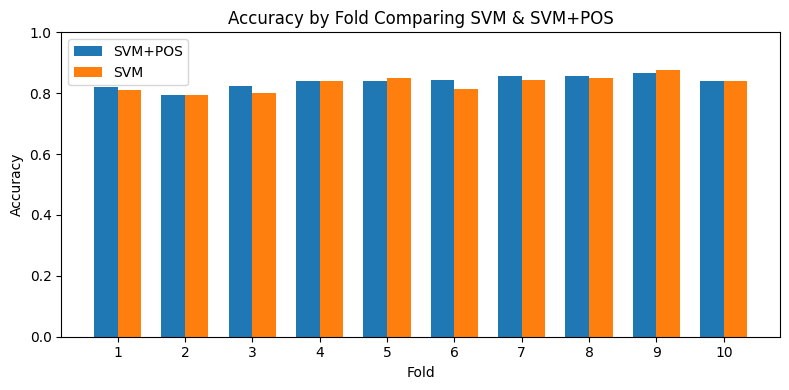

In [126]:
k = len(accs_svm_pos)
fold_idx = np.arange(1, k + 1)

fig, ax = plt.subplots(figsize=(8, 4))
width = 0.35
ax.bar(fold_idx - width/2, accs_svm_pos, width, label='SVM+POS')
ax.bar(fold_idx + width/2, accs_svm, width, label='SVM')

ax.set_xticks(fold_idx)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.set_title('Accuracy by Fold Comparing SVM & SVM+POS')
ax.legend()
fig.tight_layout()
plt.show()

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

\####################
Closed-class words do not seem detrimental to the classifier. By discarding them the model is not performing significantly worse, and in some folds it is even performing better. This makes sense because closed-class words in generall add only minor detail to the context of a sentence. When the vocabulary size is large enough, the nouns etc. seem to give enough information about the general sentiment of a review. In shorter text these closed-class words might still be needed because otherwise there is not enough information or context to classify words.  
\####################

For the final time, we'll need to adjust our `extract_pos_unigrams` function to filter (token, pos) tuples for open-class words. Use the provided structure below.

In [128]:
def extract_open_class_pos_unigrams(
    documents: list[dict], lower: bool = True
) -> list[list[tuple[str, str]]]:
    """Extracts (token, pos) tuples for open-class words only.

    Args:
        documents (list[dict]): the list of documents
        lower (bool, optional): whether to lowercase words. Defaults to True.

    Returns:
        list[list[tuple[str, str]]]: the list of (token, pos) tuple lists
    """
    ALLOWED = {
        # Nouns
        "NN", "NNS", "NNP", "NNPS",
        # Verbs
        "VB", "VBD", "VBG", "VBN", "VBP", "VBZ",
        # Adjectives
        "JJ", "JJR", "JJS",
        # Adverbs
        "RB", "RBR", "RBS",
        }


    results = []
    for doc in documents:
      token_pos = []
      for sentence in doc["content"]:
        for token, pos in sentence:
          if pos in ALLOWED:
            token = token.lower() if lower else token
            token_pos.append((token, pos))
      results.append(token_pos)
    return results


Now train, predict and evaluate your SVM classifier, and compare to the SVM with all POS tokens.

In [129]:
folds = cross_validation_splits(reviews)
accs = []
accs_svm_class = []
for i, (train_docs, test_docs) in enumerate(folds):

    # see previous exercise for accuracy of svm with all pos features
    X_train = extract_open_class_pos_unigrams(train_docs, lower=True)
    y_train = extract_labels(train_docs)
    X_test = extract_open_class_pos_unigrams(test_docs, lower=True)
    y_test = extract_labels(test_docs)

    # SVM
    X_tr, X_te = build_term_document_matrix(X_train, X_test)
    y_tr = convert_labels_to_ints(y_train)
    y_te = convert_labels_to_ints(y_test)

    #needed more iterations to converge
    svm = LinearSVC(random_state=42, max_iter=10000)
    svm.fit(X_tr, y_tr)
    preds_svm = svm.predict(X_te)


    acc_svm = accuracy(preds_svm, y_te)
    accs_svm_class.append(acc_svm)
    print(f"Fold {i+1} accuracy svm pos: {acc_svm}")

Fold 1 accuracy svm pos: 0.825
Fold 2 accuracy svm pos: 0.835
Fold 3 accuracy svm pos: 0.835
Fold 4 accuracy svm pos: 0.86
Fold 5 accuracy svm pos: 0.845
Fold 6 accuracy svm pos: 0.835
Fold 7 accuracy svm pos: 0.885
Fold 8 accuracy svm pos: 0.86
Fold 9 accuracy svm pos: 0.875
Fold 10 accuracy svm pos: 0.835


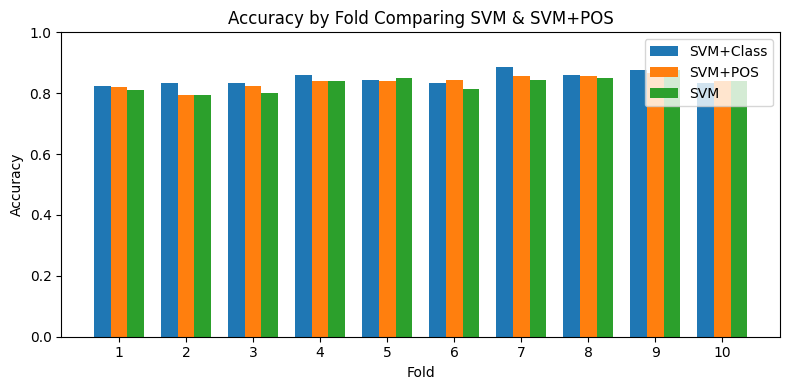

In [137]:
# svm compared
k = len(accs_svm_pos)
fold_idx = np.arange(1, k + 1)

fig, ax = plt.subplots(figsize=(8, 4))
width = 0.25
ax.bar(fold_idx - width, accs_svm_class, width, label='SVM+Class')
ax.bar(fold_idx, accs_svm_pos, width, label="SVM+POS")
ax.bar(fold_idx + width, accs_svm, width, label='SVM')

ax.set_xticks(fold_idx)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.set_title('Accuracy by Fold Comparing SVM & SVM+POS')
ax.legend()
fig.tight_layout()
plt.show()


# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.
The highest increase in accuracy was seen when performing smoothing. More n-grams does seem to make the model only slightly more accurate but it does significantly increase training time. The SVM model .....

# Use of AI tools

By submitting this notebook for grading you testify that:
* AI did not draft an earlier version of your work.
* You did not use AI-powered code completion.
* You did not implement algorithms suggested by an AI tool.
* AI did not revise a version of your work.
* You did not implement suggestions made by an AI tool.

You in the sentences above refers to you and your team member(s). AI refers to LM-based tools and assistants (e.g. ChatGPT, UvA AI Chat, Gemini, etc.).

If you did make use of an AI tool, you should describe the uses you made of it below. Or indicate that no such tool was used.

\####################
\# **YOUR ANSWER HERE** \#
\####################